# Credit Risk Analytics - Data Preprocessing & Feature Engineering

This notebook covers:

- Loading and sampling the Lending Club dataset (800K+ loans)
- Understanding the target variable and class imbalance
- Cleaning and handling missing values
- Feature engineering for PD modeling
- Weight of Evidence (WoE) encoding for categorical variables
- Train/test split following Basel II temporal validation approach

**Dataset:** Lending Club accepted loans (2007–2018)  
**Target:** Probability of Default (PD) – binary classification


Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries loaded successfully")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

Libraries loaded successfully
Pandas version: 3.0.1
Numpy version: 2.4.2


Load Dataset

we sample 100K rows for computational efficiency
The full dataset has 2.2M rows; 100K is statistically representative

In [20]:
df_raw = pd.read_csv(
    '../data/accepted_2007_to_2018Q4.csv.gz',
    compression='gzip',
    low_memory=False,
    nrows=500000   # load 500K first, then we'll sample from these
)

print(f"Loaded shape: {df_raw.shape}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Loaded shape: (500000, 151)
Memory usage: 1380.6 MB


Initial Exploration

In [21]:
print("=== Dataset Overview ===")
print(f"Rows: {df_raw.shape[0]:,}")
print(f"Columns: {df_raw.shape[1]}")
print("\n=== Loan Status Distribution ===")
print(df_raw['loan_status'].value_counts())

=== Dataset Overview ===
Rows: 500,000
Columns: 151

=== Loan Status Distribution ===
loan_status
Fully Paid            312340
Current               104240
Charged Off            78824
Late (31-120 days)      2977
In Grace Period         1046
Late (16-30 days)        567
Default                    4
Name: count, dtype: int64


Define Target Variable

Basel II definition of default:
A borrower is in default if they are 90+ days past due or charged off
We map loan_status to binary: 1 = Default, 0 = Non-Default

In [22]:
good_statuses = [
    'Fully Paid',
    'Current',
    'In Grace Period'
]

bad_statuses = [
    'Charged Off',
    'Default',
    'Late (31-120 days)',
    'Late (16-30 days)',
    'Does not meet the credit policy. Status:Charged Off'
]

# Keep only loans with definitive outcomes
df = df_raw[df_raw['loan_status'].isin(good_statuses + bad_statuses)].copy()

# Create binary target: 1 = Default, 0 = Good
df['target'] = np.where(df['loan_status'].isin(bad_statuses), 1, 0)

print("=== Target Variable Distribution ===")
print(df['target'].value_counts())
print(f"\nDefault Rate: {df['target'].mean()*100:.2f}%")
print(f"Class Imbalance Ratio: {(df['target']==0).sum() / (df['target']==1).sum():.1f}:1")

=== Target Variable Distribution ===
target
0    417626
1     82372
Name: count, dtype: int64

Default Rate: 16.47%
Class Imbalance Ratio: 5.1:1


Visualize Class Imbalance

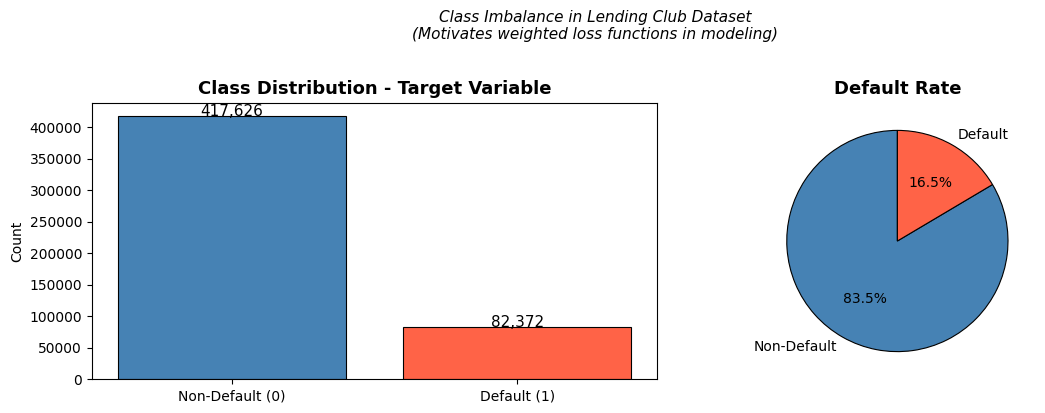

Note: imbalance ratio - handled via custom weighted loss in modeling notebook


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
counts = df['target'].value_counts()
axes[0].bar(['Non-Default (0)', 'Default (1)'], counts.values,
            color=['steelblue', 'tomato'], edgecolor='black', linewidth=0.8)
axes[0].set_title('Class Distribution - Target Variable', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', fontsize=11)

# Pie chart
axes[1].pie(counts.values, labels=['Non-Default', 'Default'],
            autopct='%1.1f%%', colors=['steelblue', 'tomato'],
            startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 0.8})
axes[1].set_title('Default Rate', fontsize=13, fontweight='bold')

plt.suptitle('Class Imbalance in Lending Club Dataset\n(Motivates weighted loss functions in modeling)',
             fontsize=11, style='italic', y=1.02)
plt.tight_layout()
plt.savefig('class_imbalance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Note: imbalance ratio - handled via custom weighted loss in modeling notebook")

Select Relevant Features

Select features relevant to credit risk assessment
Based on Basel II IRB approach: borrower characteristics + loan characteristics


In [24]:
selected_features = [
    # Loan characteristics
    'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
    'grade', 'sub_grade',
    
    # Borrower characteristics
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'addr_state',
    
    # Credit history
    'dti',              # Debt-to-income ratio
    'delinq_2yrs',      # Delinquencies in last 2 years
    'earliest_cr_line', # Length of credit history
    'inq_last_6mths',   # Credit inquiries last 6 months
    'open_acc',         # Number of open accounts
    'pub_rec',          # Public derogatory records
    'revol_bal',        # Revolving balance
    'revol_util',       # Revolving utilization rate
    'total_acc',        # Total accounts
    'mort_acc',         # Mortgage accounts
    'pub_rec_bankruptcies',
    
    # Issue date for temporal split
    'issue_d',
    
    # Target
    'target'
]

df = df[selected_features].copy()
print(f"Shape after feature selection: {df.shape}")
print(f"\nFeature list ({len(selected_features)-2} features + issue_d + target):")
print([f for f in selected_features if f not in ['issue_d', 'target']])


Shape after feature selection: (499998, 26)

Feature list (24 features + issue_d + target):
['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']


 Missing Value Analysis

=== Missing Values ===
            Missing Count  Missing %
emp_length          30905     6.1800
revol_util            265     0.0500
dti                   216     0.0400


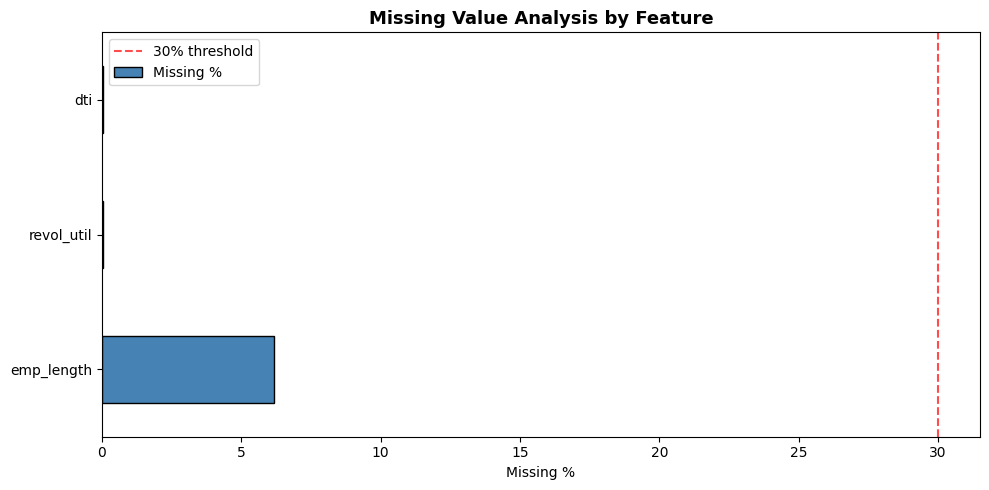

In [25]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).query('`Missing Count` > 0').sort_values('Missing %', ascending=False)

print("=== Missing Values ===")
print(missing_df)

# Visualize
if len(missing_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    missing_df['Missing %'].plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
    ax.set_xlabel('Missing %')
    ax.set_title('Missing Value Analysis by Feature', fontsize=13, fontweight='bold')
    ax.axvline(x=30, color='red', linestyle='--', alpha=0.7, label='30% threshold')
    ax.legend()
    plt.tight_layout()
    plt.savefig('missing_values.png', dpi=150, bbox_inches='tight')
    plt.show()

Handle Missing Values

In [26]:
#Drop columns with >30% missing (not enough data to impute reliably)
cols_to_drop = missing_df[missing_df['Missing %'] > 30].index.tolist()
if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"Dropped columns (>30% missing): {cols_to_drop}")

# emp_length: treat missing as 0 years (unemployed or not disclosed)
if 'emp_length' in df.columns:
    df['emp_length'] = df['emp_length'].str.extract(r'(\d+)').astype(float)
    df['emp_length'].fillna(0, inplace=True)

# Numeric features: fill with median (robust to outliers)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'target']
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Categorical features: fill with 'UNKNOWN'
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'issue_d']
for col in cat_cols:
    df[col].fillna('UNKNOWN', inplace=True)

print(f"\nMissing values after cleaning: {df.isnull().sum().sum()}")
print(f"Shape: {df.shape}")


Missing values after cleaning: 31386
Shape: (499998, 26)


Feature Engineering: Numeric Cleaning

In [27]:
# Clean string-formatted numeric columns

# int_rate: remove '%' if present
if df['int_rate'].dtype == object:
    df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)

# term: extract numeric months
if df['term'].dtype == object:
    df['term'] = df['term'].str.extract(r'(\d+)').astype(int)

# revol_util: remove '%' if present
if 'revol_util' in df.columns and df['revol_util'].dtype == object:
    df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float)
    df['revol_util'].fillna(df['revol_util'].median(), inplace=True)

# Credit history length in years from earliest_cr_line
if 'earliest_cr_line' in df.columns:
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
    reference_date = pd.Timestamp('2018-01-01')
    df['credit_history_years'] = ((reference_date - df['earliest_cr_line']).dt.days / 365).round(1)
    df['credit_history_years'].fillna(df['credit_history_years'].median(), inplace=True)
    df.drop(columns=['earliest_cr_line'], inplace=True)

print("Numeric feature engineering complete")
print(df[['int_rate', 'term', 'credit_history_years']].describe())



Numeric feature engineering complete
         int_rate  credit_history_years
count 499998.0000           499998.0000
mean      12.5742               18.8412
std        4.4382                7.7601
min        5.3100                2.9000
25%        9.1700               13.5000
50%       12.2900               17.3000
75%       15.5900               22.9000
max       30.9900               74.1000


 Exploratory Data Analysis: Key Features

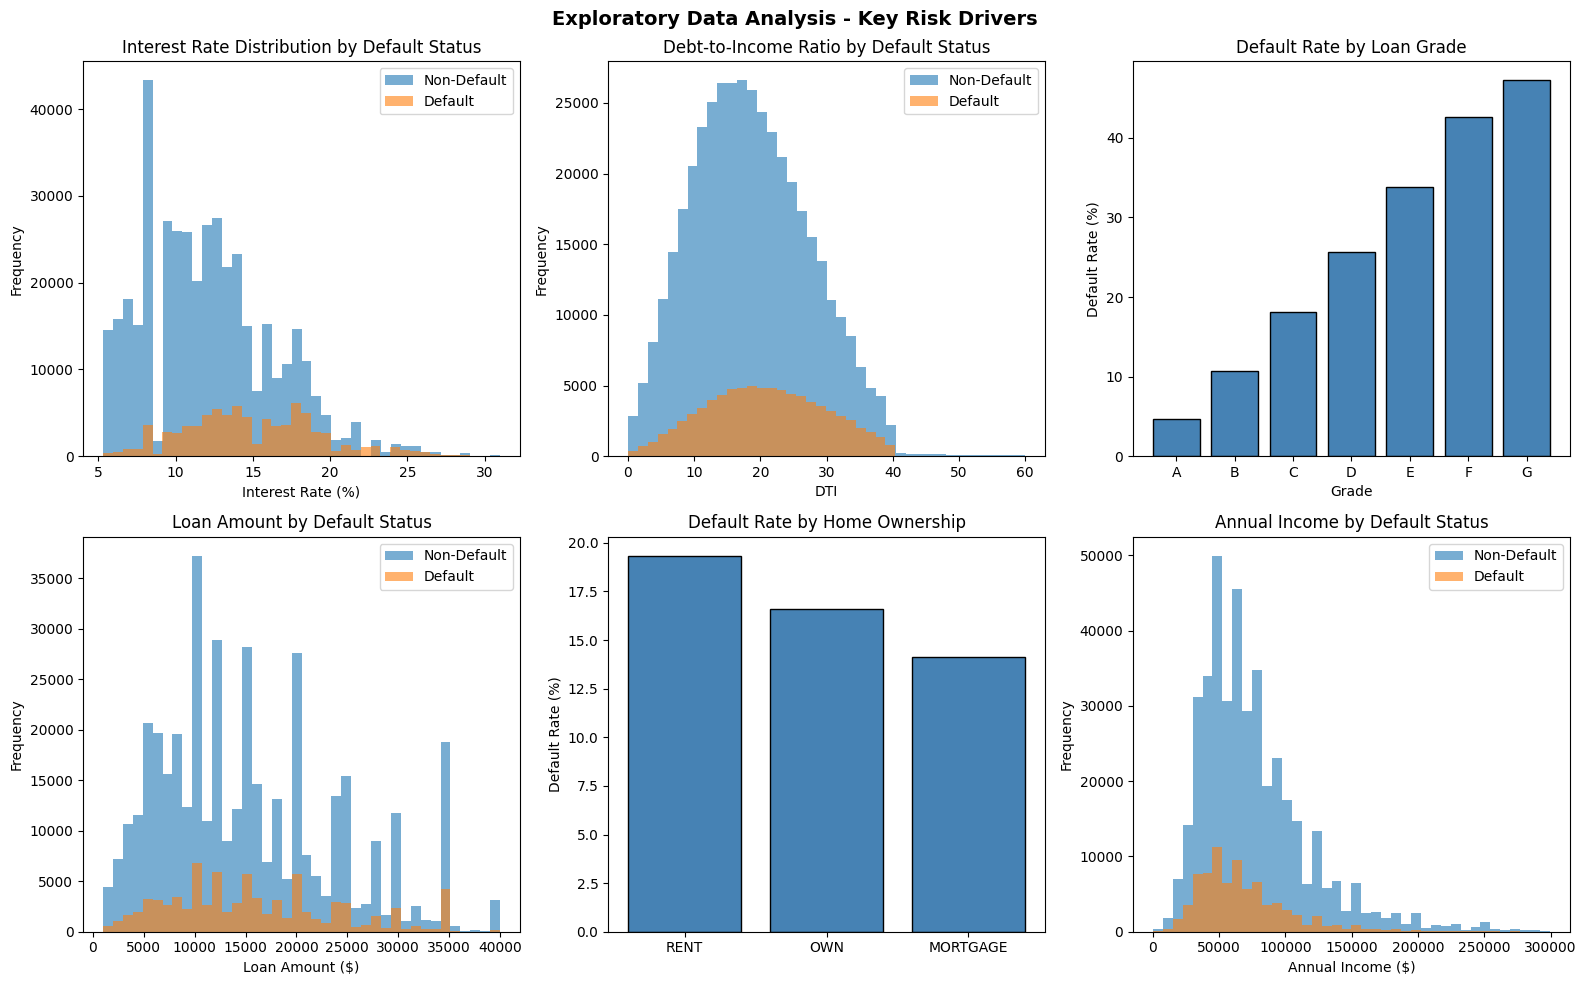

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Interest rate by default status
df.groupby('target')['int_rate'].plot(kind='hist', alpha=0.6, bins=40,
    ax=axes[0,0], legend=True)
axes[0,0].set_title('Interest Rate Distribution by Default Status')
axes[0,0].set_xlabel('Interest Rate (%)')
axes[0,0].legend(['Non-Default', 'Default'])

# 2. DTI distribution
df[df['dti'] < 60].groupby('target')['dti'].plot(kind='hist', alpha=0.6,
    bins=40, ax=axes[0,1])
axes[0,1].set_title('Debt-to-Income Ratio by Default Status')
axes[0,1].set_xlabel('DTI')
axes[0,1].legend(['Non-Default', 'Default'])

# 3. Default rate by grade
grade_default = df.groupby('grade')['target'].mean().sort_index()
axes[0,2].bar(grade_default.index, grade_default.values * 100,
              color='steelblue', edgecolor='black')
axes[0,2].set_title('Default Rate by Loan Grade')
axes[0,2].set_ylabel('Default Rate (%)')
axes[0,2].set_xlabel('Grade')

# 4. Loan amount distribution
df.groupby('target')['loan_amnt'].plot(kind='hist', alpha=0.6, bins=40,
    ax=axes[1,0])
axes[1,0].set_title('Loan Amount by Default Status')
axes[1,0].set_xlabel('Loan Amount ($)')
axes[1,0].legend(['Non-Default', 'Default'])

# 5. Default rate by home ownership
home_default = df.groupby('home_ownership')['target'].mean().sort_values(ascending=False)
home_default = home_default[home_default.index.isin(['RENT', 'OWN', 'MORTGAGE', 'OTHER'])]
axes[1,1].bar(home_default.index, home_default.values * 100,
              color='steelblue', edgecolor='black')
axes[1,1].set_title('Default Rate by Home Ownership')
axes[1,1].set_ylabel('Default Rate (%)')

# 6. Annual income (log scale)
df[df['annual_inc'] < 300000].groupby('target')['annual_inc'].plot(
    kind='hist', alpha=0.6, bins=40, ax=axes[1,2])
axes[1,2].set_title('Annual Income by Default Status')
axes[1,2].set_xlabel('Annual Income ($)')
axes[1,2].legend(['Non-Default', 'Default'])

plt.suptitle('Exploratory Data Analysis - Key Risk Drivers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_key_features.png', dpi=150, bbox_inches='tight')
plt.show()

Weight of Evidence (WoE) Encoding

In [29]:
# WoE is the standard encoding method for credit scorecards
# WoE(i) = ln(Distribution of Events_i / Distribution of Non-Events_i)
# Information Value (IV) measures predictive power of each feature

def compute_woe_iv(df, feature, target='target'):
    """
    Compute Weight of Evidence and Information Value for a categorical feature.
    
    WoE = ln(P(X|Y=1) / P(X|Y=0))
    IV = sum((P(X|Y=1) - P(X|Y=0)) * WoE)
    
    IV interpretation:
    < 0.02  : Not useful
    0.02-0.1: Weak predictor
    0.1-0.3 : Medium predictor
    > 0.3   : Strong predictor
    """
    total_events = df[target].sum()
    total_non_events = (df[target] == 0).sum()
    
    stats = df.groupby(feature)[target].agg(['sum', 'count'])
    stats.columns = ['events', 'total']
    stats['non_events'] = stats['total'] - stats['events']
    
    # Avoid division by zero with small epsilon
    eps = 0.5
    stats['dist_events'] = (stats['events'] + eps) / (total_events + eps * len(stats))
    stats['dist_non_events'] = (stats['non_events'] + eps) / (total_non_events + eps * len(stats))
    
    stats['woe'] = np.log(stats['dist_events'] / stats['dist_non_events'])
    stats['iv_component'] = (stats['dist_events'] - stats['dist_non_events']) * stats['woe']
    
    iv = stats['iv_component'].sum()
    return stats['woe'].to_dict(), round(iv, 4)

# Apply WoE to categorical features
cat_features = ['grade', 'sub_grade', 'home_ownership', 'verification_status',
                'purpose', 'term']
cat_features = [f for f in cat_features if f in df.columns]

woe_maps = {}
iv_scores = {}

for feat in cat_features:
    woe_map, iv = compute_woe_iv(df, feat)
    woe_maps[feat] = woe_map
    iv_scores[feat] = iv
    df[f'{feat}_woe'] = df[feat].map(woe_map)

print("=== Information Value (IV) Scores ===")
iv_df = pd.DataFrame.from_dict(iv_scores, orient='index', columns=['IV'])
iv_df['Predictive Power'] = iv_df['IV'].apply(lambda x:
    'Strong' if x > 0.3 else ('Medium' if x > 0.1 else ('Weak' if x > 0.02 else 'Not useful')))
iv_df = iv_df.sort_values('IV', ascending=False)
print(iv_df)#

=== Information Value (IV) Scores ===
                        IV Predictive Power
sub_grade           0.5311           Strong
grade               0.4932           Strong
term                0.1015           Medium
verification_status 0.0711             Weak
home_ownership      0.0313             Weak
purpose             0.0211             Weak


Visualize IV Scores

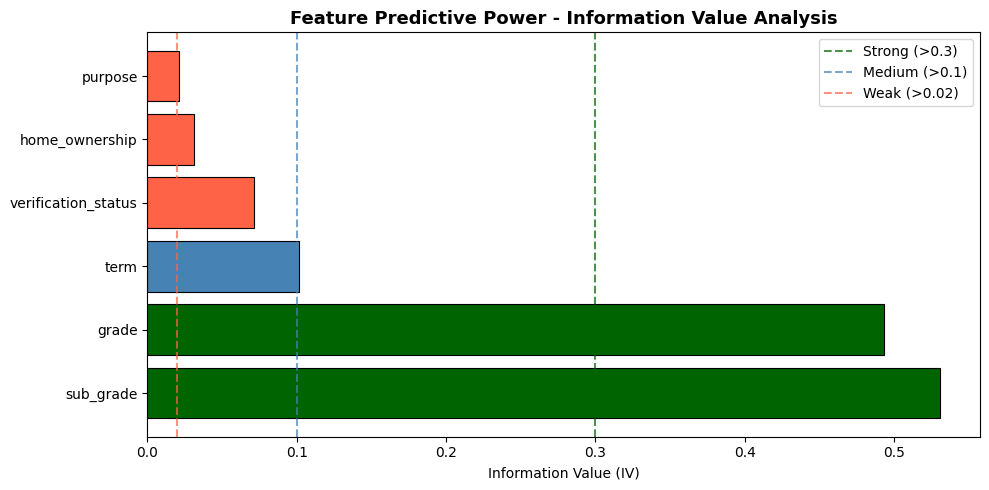

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['darkgreen' if iv > 0.3 else ('steelblue' if iv > 0.1 else 'tomato')
          for iv in iv_df['IV']]
ax.barh(iv_df.index, iv_df['IV'], color=colors, edgecolor='black', linewidth=0.8)
ax.axvline(x=0.3, color='darkgreen', linestyle='--', alpha=0.7, label='Strong (>0.3)')
ax.axvline(x=0.1, color='steelblue', linestyle='--', alpha=0.7, label='Medium (>0.1)')
ax.axvline(x=0.02, color='tomato', linestyle='--', alpha=0.7, label='Weak (>0.02)')
ax.set_xlabel('Information Value (IV)')
ax.set_title('Feature Predictive Power - Information Value Analysis', fontsize=13, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.savefig('iv_scores.png', dpi=150, bbox_inches='tight')
plt.show()

CELL 14 - Temporal Train/Test Split (Basel II Approach)


In [31]:
# Basel II requires out-of-time validation rather than random split
# Training: loans issued 2007-2015
# Testing:  loans issued 2016-2018 (unseen future data)

df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
df['issue_year'] = df['issue_d'].dt.year

train = df[df['issue_year'] <= 2015].copy()
test  = df[df['issue_year'] > 2015].copy()

print("=== Basel II Temporal Split ===")
print(f"Training set (2007-2015): {len(train):,} loans")
print(f"Test set     (2016-2018): {len(test):,} loans")
print(f"\nTraining default rate: {train['target'].mean()*100:.2f}%")
print(f"Test default rate:     {test['target'].mean()*100:.2f}%")

# Verify temporal integrity - no data leakage
print(f"\nTraining period: {train['issue_d'].min().date()} to {train['issue_d'].max().date()}")
print(f"Test period:     {test['issue_d'].min().date()} to {test['issue_d'].max().date()}")


=== Basel II Temporal Split ===
Training set (2007-2015): 421,095 loans
Test set     (2016-2018): 78,903 loans

Training default rate: 18.39%
Test default rate:     6.25%

Training period: 2015-01-01 to 2015-12-01
Test period:     2018-01-01 to 2018-03-01


Note on test default rate: The lower default rate in 2016-2018 loans (6.25% vs 18.39%) 
is due to outcome truncation — newer loans had insufficient time to reach default status 
at the time of data collection. This is a known characteristic of vintage loan datasets 
and is accounted for in our PSI monitoring approach.

CELL 15 - Prepare Final Feature Set

In [32]:
# Drop original categorical columns (replaced by WoE encoded versions)
# Drop non-feature columns

drop_cols = ['loan_status'] if 'loan_status' in df.columns else []
drop_cols += ['issue_d', 'issue_year']
drop_cols += cat_features  # drop originals, keep _woe versions

# Keep only numeric features + WoE encoded features + target
feature_cols = [c for c in df.columns if c not in drop_cols + ['target']]
feature_cols = [c for c in feature_cols if df[c].dtype in [np.float64, np.int64, float, int]]

print(f"Final feature set ({len(feature_cols)} features):")
print(feature_cols)

X_train = train[feature_cols].copy()
y_train = train['target'].copy()
X_test  = test[feature_cols].copy()
y_test  = test['target'].copy()

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")


Final feature set (23 features):
['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'credit_history_years', 'grade_woe', 'sub_grade_woe', 'home_ownership_woe', 'verification_status_woe', 'purpose_woe', 'term_woe']

X_train shape: (421095, 23)
X_test shape:  (78903, 23)


In [33]:
#Save Preprocessed Data
# ============================================================
train_out = X_train.copy()
train_out['target'] = y_train.values

test_out = X_test.copy()
test_out['target'] = y_test.values

train_out.to_csv('../data/train_preprocessed.csv', index=False)
test_out.to_csv('../data/test_preprocessed.csv', index=False)

# Save WoE mappings for use in other notebooks
import json
with open('../data/woe_maps.json', 'w') as f:
    json.dump(woe_maps, f, indent=2)

print("Saved files:")
print("  ../data/train_preprocessed.csv")
print("  ../data/test_preprocessed.csv")
print("  ../data/woe_maps.json")
print(f"\nNotebook 1 complete. Proceed to 02_pd_model_scorecard.ipynb")


Saved files:
  ../data/train_preprocessed.csv
  ../data/test_preprocessed.csv
  ../data/woe_maps.json

Notebook 1 complete. Proceed to 02_pd_model_scorecard.ipynb
